In [1]:
import pandas as pd
import psycopg2
import csv
import sys
import datasets
import get_notes
import concat_and_split_full
from collections import Counter, defaultdict
import operator
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_data(query):
    conn = psycopg2.connect(dbname="mimic", user="beth", password="")
    """ query data from the vendors table """
    try:
        cur = conn.cursor()
        cur.execute(query)
        print("The number of parts: ", cur.rowcount)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    return cur

## Admission table

In [17]:
row = get_data("SELECT * FROM mimiciii.admissions")
df_Adm = pd.DataFrame(row)
df_Adm.rename(columns={0: 'ROW_ID',
                           1: 'SUBJECT_ID',
                           2: 'HADM_ID',
                           3: 'ADMITTIME',
                           4: 'DISCHTIME',
                          }, inplace=True)
df_Adm


The number of parts:  58976


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


In [18]:
df_Adm['ADMITTIME'] = pd.to_datetime(df_Adm['ADMITTIME']).dt.date
df_Adm

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,21,22,165315,2196-04-09,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30,2131-04-02 15:02:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58972,58595,98802,101071,2151-03-05,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1
58973,58596,98805,122631,2200-09-12,2200-09-20 12:08:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11,2128-12-22 13:11:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


## Reformat diagnoses codes

In [4]:
row = get_data("SELECT * FROM mimiciii.diagnoses_icd")
df_DiagICD = pd.DataFrame(row)
df_DiagICD.rename(columns={0: 'ROW_ID',
                           1: 'SUBJECT_ID',
                           2: 'HADM_ID',
                           3: 'SEQ_NUM',
                           4: 'ICD9_CODE', 
                          }, inplace=True)
df_DiagICD



The number of parts:  651047


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


In [5]:
df_DiagICD['absolute_code'] = df_DiagICD.apply(lambda row: str(datasets.reformat(str(row[4]), True)), axis=1)
df_DiagICD



,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,absolute_code
0,1297,109,172335,1.0,40301,403.01
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582.81
3,1300,109,172335,4.0,5855,585.5
4,1301,109,172335,5.0,4254,425.4
...,...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280,202.80
651043,639799,97503,188195,3.0,V5869,V58.69
651044,639800,97503,188195,4.0,V1279,V12.79
651045,639801,97503,188195,5.0,5275,527.5


In [6]:
df_DiagICD.to_csv('./DiagICD.csv', index=False,
               columns=['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'absolute_code'],
               header=['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'])

In [7]:
df = pd.read_csv('./DiagICD.csv', dtype={"ICD9_CODE": str})
len(df['ICD9_CODE'].unique())

6985

In [10]:
df

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,403.01
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,582.81
3,1300,109,172335,4.0,585.5
4,1301,109,172335,5.0,425.4
...,...,...,...,...,...
891137,228330,67415,150871,5.0,37.36
891138,228331,67415,150871,6.0,38.93
891139,228332,67415,150871,7.0,88.72
891140,228333,67415,150871,8.0,38.93


## Noteevents table

In [3]:
row = get_data("SELECT category, COUNT(category) FROM mimiciii.noteevents GROUP BY category")
for r in row:
    print(r)

The number of parts:  15
('Case Management ', 967)
('Consult', 98)
('Discharge summary', 59652)
('ECG', 209051)
('Echo', 45794)
('General', 8301)
('Nursing', 223556)
('Nursing/other', 822497)
('Nutrition', 9418)
('Pharmacy', 103)
('Physician ', 141624)
('Radiology', 522279)
('Rehab Services', 5431)
('Respiratory ', 31739)
('Social Work', 2670)


### Tokenize and preprocess raw text

In [8]:
row = get_data("SELECT * FROM mimiciii.noteevents")
df_FullEvents = pd.DataFrame(row)
df_FullEvents.rename(columns={0: 'ROW_ID',
                          1: 'SUBJECT_ID',
                          2: 'HADM_ID',
                          3: 'CHARTDATE',
                          4: 'CHARTTIME', 
                          5: 'STORETIME', 
                          6: 'CATEGORY', 
                          7: 'DESCRIPTION', 
                          8: 'CGID', 
                          9: 'ISERROR', 
                          10: 'TEXT', 
                         }, inplace=True)
df_FullEvents

The number of parts:  2083180


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,2060064,30003,120717.0,2128-12-27,2128-12-27 18:19:00,2128-12-27 18:42:00,Nursing/other,Report,18869.0,None,"NPN 0700-1900\n\n\nFEN ad lib, E20/BM, taking..."
1,2060124,30005,179076.0,2113-01-12,2113-01-12 14:33:00,2113-01-12 14:39:00,Nursing/other,Report,20522.0,None,Nursing Progress Note\n\n\n1. RESP Received ...
2,2060125,30005,179076.0,2113-01-12,2113-01-12 14:45:00,2113-01-12 14:50:00,Nursing/other,Report,19211.0,None,"Neonatology\nDOL #8, CGA 29 6/7 weeks.\n\nCVR:..."
3,2060126,30005,179076.0,2113-01-12,2113-01-12 20:27:00,2113-01-12 20:33:00,Nursing/other,Report,20835.0,None,[** 63**] PE\nBB Girl [**Known lastname 3478**...
4,2060192,30005,179076.0,2113-01-27,2113-01-27 12:45:00,2113-01-27 12:48:00,Nursing/other,Report,20522.0,None,Nursing Progress Note\n\n\n1. RESP Received ...
...,...,...,...,...,...,...,...,...,...,...,...
2083175,2060062,30003,120717.0,2128-12-27,2128-12-27 06:15:00,2128-12-27 06:30:00,Nursing/other,Report,17604.0,None,Nursing Admission note\nBaby [**Name (NI) **] ...
2083176,2060063,30003,120717.0,2128-12-27,2128-12-27 07:36:00,2128-12-27 07:46:00,Nursing/other,Report,17335.0,None,Neonatology Attending\n35-6/7 week GA infnat a...
2083177,2050972,28708,136365.0,2181-11-10,2181-11-10 14:22:00,2181-11-10 14:23:00,Nursing/other,Report,19412.0,None,Respiratory Care\nPt cont on HFNC 1.5ml/28%. b...
2083178,668926,62927,109943.0,2173-03-31,2173-03-31 07:05:00,2173-03-31 07:05:37,Physician,Physician Resident Progress Note,18281.0,None,Chief Complaint:\n 24 Hour Events:\n - ACT...


In [13]:
df_FullEvents.isnull().sum()

ROW_ID               0
SUBJECT_ID           0
HADM_ID         231836
CHARTDATE            0
CHARTTIME       316566
STORETIME       836776
CATEGORY             0
DESCRIPTION          0
CGID            836776
ISERROR        2082294
TEXT                 0
dtype: int64

In [9]:
#df_FullEvents = df_FullEvents.drop(df_FullEvents[(df_FullEvents['CATEGORY'] != 'Discharge summary') & (df_FullEvents['CHARTTIME'].isnull())].index)

In [15]:
df_FullEvents.isnull().sum()


ROW_ID               0
SUBJECT_ID           0
HADM_ID         147149
CHARTDATE            0
CHARTTIME        59652
STORETIME       581931
CATEGORY             0
DESCRIPTION          0
CGID            581931
ISERROR        1825380
TEXT                 0
dtype: int64

In [2]:
full_file = get_notes.write_notes(out_file="./full_events.csv")


processing notes file


52it [00:00, 511.72it/s]

writing to ./full_events.csv


2083180it [08:20, 4166.36it/s] 


In [3]:
df = pd.read_csv('./full_events.csv')
len(df['HADM_ID'].unique())

/Users/beth/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


58362

In [4]:
df.isnull().sum()

SUBJECT_ID        0
HADM_ID           0
CHARTDATE         0
CHARTTIME     59652
TEXT              0
dtype: int64

In [4]:
df = df.drop(df[(df['HADM_ID'].isnull()) | (df['TEXT'].isnull())].index)


In [6]:
df.isnull().sum()

SUBJECT_ID        0
HADM_ID           0
CHARTDATE         0
CHARTTIME     59652
TEXT              0
dtype: int64

In [5]:
df = df.sort_values(['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME'])
dflabels = pd.read_csv('./DiagICD.csv')
dflabels = dflabels.sort_values(['SUBJECT_ID', 'HADM_ID'])

In [5]:
df['CHARTDATE'] = pd.to_datetime(df['CHARTDATE'])


In [6]:
df

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,CATEGORY,TEXT
1671574,2,163353.0,2138-07-17,2138-07-17 22:51:00,Nursing/other,neonatology attending triage note baby name ni...
1671019,2,163353.0,2138-07-17,2138-07-17 23:08:00,Nursing/other,nursing transfer note pt admitted to nicu for ...
766194,3,145834.0,2101-10-20,2101-10-20 17:49:00,Radiology,pm ct abdomen w o contrast ct pelvis w o contr...
766114,3,145834.0,2101-10-20,2101-10-20 18:16:00,Radiology,pm chest portable ap clip clip number radiolog...
765990,3,145834.0,2101-10-20,2101-10-20 22:23:00,Radiology,pm chest portable ap clip clip number radiolog...
...,...,...,...,...,...,...
718558,99999,113369.0,2118-01-01,2118-01-01 05:32:00,Physician,sicu hpi f pod1 s p plif with respiratory dist...
718850,99999,113369.0,2118-01-01,2118-01-01 05:32:00,Physician,sicu hpi f pod1 s p plif with respiratory dist...
719695,99999,113369.0,2118-01-01,2118-01-01 13:01:00,Nursing,yo f with history of neurogenic claudication c...
719697,99999,113369.0,2118-01-01,2118-01-01 13:01:00,Nursing,yo f with history of neurogenic claudication c...


### Prepare first ? days notes for each admission

In [8]:
long = (df.groupby('HADM_ID')['CHARTDATE'].apply(lambda g: g.iloc[-1] - g.iloc[0])).to_frame()

In [9]:
long.reset_index(inplace=True)

In [10]:
long.columns = ['HADM_ID', 'duration']

In [11]:
long['duration'] = long.duration.apply(lambda x: x.days)


In [12]:
long

,HADM_ID,duration
0,100001.0,6
1,100003.0,4
2,100006.0,12
3,100007.0,7
4,100009.0,5
...,...,...
58356,199993.0,25
58357,199994.0,10
58358,199995.0,17
58359,199998.0,6


In [13]:
dflo = pd.merge(df,long)
dflo


,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,CATEGORY,TEXT,duration
0,2,163353.0,2138-07-17,2138-07-17 22:51:00,Nursing/other,neonatology attending triage note baby name ni...,0
1,2,163353.0,2138-07-17,2138-07-17 23:08:00,Nursing/other,nursing transfer note pt admitted to nicu for ...,0
2,3,145834.0,2101-10-20,2101-10-20 17:49:00,Radiology,pm ct abdomen w o contrast ct pelvis w o contr...,11
3,3,145834.0,2101-10-20,2101-10-20 18:16:00,Radiology,pm chest portable ap clip clip number radiolog...,11
4,3,145834.0,2101-10-20,2101-10-20 22:23:00,Radiology,pm chest portable ap clip clip number radiolog...,11
...,...,...,...,...,...,...,...
1851264,99999,113369.0,2118-01-01,2118-01-01 05:32:00,Physician,sicu hpi f pod1 s p plif with respiratory dist...,4
1851265,99999,113369.0,2118-01-01,2118-01-01 05:32:00,Physician,sicu hpi f pod1 s p plif with respiratory dist...,4
1851266,99999,113369.0,2118-01-01,2118-01-01 13:01:00,Nursing,yo f with history of neurogenic claudication c...,4
1851267,99999,113369.0,2118-01-01,2118-01-01 13:01:00,Nursing,yo f with history of neurogenic claudication c...,4


In [14]:
dflo = dflo.drop(dflo[dflo['duration']<8].index)

In [16]:
dflo = dflo.drop(dflo[dflo['CATEGORY']!='Discharge summary'].index)
dflo

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,CATEGORY,TEXT,duration
47,3,145834.0,2101-10-31,NaN,Discharge summary,admission date discharge date date of birth se...,11
61,4,185777.0,2191-03-23,NaN,Discharge summary,admission date discharge date date of birth se...,8
85,6,107064.0,2175-06-15,NaN,Discharge summary,admission date discharge date date of birth se...,16
173,10,184167.0,2103-07-06,NaN,Discharge summary,admission date discharge date date of birth se...,8
192,11,194540.0,2178-05-11,NaN,Discharge summary,admission date discharge date date of birth se...,25
...,...,...,...,...,...,...,...
1850980,99957,148574.0,2157-03-04,NaN,Discharge summary,admission date discharge date date of birth se...,11
1851050,99982,112748.0,2157-01-12,NaN,Discharge summary,admission date discharge date date of birth se...,8
1851064,99982,151454.0,2156-12-08,NaN,Discharge summary,admission date discharge date date of birth se...,16
1851210,99985,176670.0,2181-02-12,NaN,Discharge summary,admission date discharge date date of birth se...,16


In [24]:
dflo.to_csv('./date_disch.csv', index=False)

In [19]:
Adm_dt = pd.DataFrame(df_Adm, columns=['HADM_ID', 'ADMITTIME'])
Adm_dt

,HADM_ID,ADMITTIME
0,165315,2196-04-09
1,152223,2153-09-03
2,124321,2157-10-18
3,161859,2139-06-06
4,129635,2160-11-02
...,...,...
58971,191113,2131-03-30
58972,101071,2151-03-05
58973,122631,2200-09-12
58974,170407,2128-11-11


In [20]:
df_dated = pd.merge(dflo,Adm_dt)
df_dated

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT,duration,ADMITTIME
0,3,145834.0,2101-10-20,2101-10-20 17:49:00,pm ct abdomen w o contrast ct pelvis w o contr...,11,2101-10-20
1,3,145834.0,2101-10-20,2101-10-20 18:16:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20
2,3,145834.0,2101-10-20,2101-10-20 22:23:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20
3,3,145834.0,2101-10-20,NaN,sinus rhythm inferior lateral t changes are no...,11,2101-10-20
4,3,145834.0,2101-10-21,2101-10-21 01:00:00,am chest portable ap clip clip number radiolog...,11,2101-10-20
...,...,...,...,...,...,...,...
1426211,99991,151118.0,2184-12-31,2184-12-31 15:22:00,s p lap sigmoid colectomy for reoccurring dive...,9,2184-12-24
1426212,99991,151118.0,2184-12-31,2184-12-31 16:03:00,subjective i m ready to walk objective follow ...,9,2184-12-24
1426213,99991,151118.0,2184-12-31,2184-12-31 20:00:00,s p lap sigmoid colectomy for reoccurring dive...,9,2184-12-24
1426214,99991,151118.0,2185-01-01,2185-01-01 15:02:00,pm heel axial lateral left clip clip number ra...,9,2184-12-24


In [21]:
df_dated['ADMITTIME'] = pd.to_datetime(df_dated['ADMITTIME'])
df_dated['dateofnote'] = df_dated['CHARTDATE'] - df_dated['ADMITTIME']
df_dated['dateofnote'] = df_dated.dateofnote.apply(lambda x: x.days)
df_dated

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT,duration,ADMITTIME,dateofnote
0,3,145834.0,2101-10-20,2101-10-20 17:49:00,pm ct abdomen w o contrast ct pelvis w o contr...,11,2101-10-20,0
1,3,145834.0,2101-10-20,2101-10-20 18:16:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
2,3,145834.0,2101-10-20,2101-10-20 22:23:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
3,3,145834.0,2101-10-20,NaN,sinus rhythm inferior lateral t changes are no...,11,2101-10-20,0
4,3,145834.0,2101-10-21,2101-10-21 01:00:00,am chest portable ap clip clip number radiolog...,11,2101-10-20,1
...,...,...,...,...,...,...,...,...
1426211,99991,151118.0,2184-12-31,2184-12-31 15:22:00,s p lap sigmoid colectomy for reoccurring dive...,9,2184-12-24,7
1426212,99991,151118.0,2184-12-31,2184-12-31 16:03:00,subjective i m ready to walk objective follow ...,9,2184-12-24,7
1426213,99991,151118.0,2184-12-31,2184-12-31 20:00:00,s p lap sigmoid colectomy for reoccurring dive...,9,2184-12-24,7
1426214,99991,151118.0,2185-01-01,2185-01-01 15:02:00,pm heel axial lateral left clip clip number ra...,9,2184-12-24,8


#### First week

In [22]:
df_week = df_dated.drop(df_dated[df_dated['dateofnote']>6].index)
df_week

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT,duration,ADMITTIME,dateofnote
0,3,145834.0,2101-10-20,2101-10-20 17:49:00,pm ct abdomen w o contrast ct pelvis w o contr...,11,2101-10-20,0
1,3,145834.0,2101-10-20,2101-10-20 18:16:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
2,3,145834.0,2101-10-20,2101-10-20 22:23:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
3,3,145834.0,2101-10-20,NaN,sinus rhythm inferior lateral t changes are no...,11,2101-10-20,0
4,3,145834.0,2101-10-21,2101-10-21 01:00:00,am chest portable ap clip clip number radiolog...,11,2101-10-20,1
...,...,...,...,...,...,...,...,...
1426198,99991,151118.0,2184-12-30,2184-12-30 00:26:00,is p bowel resection assessment abd slightly d...,9,2184-12-24,6
1426199,99991,151118.0,2184-12-30,2184-12-30 02:58:00,title hour events arterial line start pm multi...,9,2184-12-24,6
1426200,99991,151118.0,2184-12-30,2184-12-30 02:58:00,title hour events arterial line start pm multi...,9,2184-12-24,6
1426201,99991,151118.0,2184-12-30,2184-12-30 09:16:00,attending physician name10 nameis referral dat...,9,2184-12-24,6


In [26]:
df_week.to_csv('./df_week.csv', index=False)


#### First 2 days

In [27]:
df_second = df_dated.drop(df_dated[df_dated['dateofnote']>1].index)
df_second

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT,duration,ADMITTIME,dateofnote
0,3,145834.0,2101-10-20,2101-10-20 17:49:00,pm ct abdomen w o contrast ct pelvis w o contr...,11,2101-10-20,0
1,3,145834.0,2101-10-20,2101-10-20 18:16:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
2,3,145834.0,2101-10-20,2101-10-20 22:23:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
3,3,145834.0,2101-10-20,NaN,sinus rhythm inferior lateral t changes are no...,11,2101-10-20,0
4,3,145834.0,2101-10-21,2101-10-21 01:00:00,am chest portable ap clip clip number radiolog...,11,2101-10-20,1
...,...,...,...,...,...,...,...,...
1426035,99982,151454.0,2156-11-28,2156-11-28 15:32:00,pm chest port line placement clip clip number ...,16,2156-11-28,0
1426036,99982,151454.0,2156-11-29,2156-11-29 12:49:00,pm chest port line placement clip clip number ...,16,2156-11-28,1
1426037,99982,151454.0,2156-11-29,NaN,patient test information indication atrial fib...,16,2156-11-28,1
1426038,99982,151454.0,2156-11-29,NaN,sinus rhythm with atrial premature beats gener...,16,2156-11-28,1


In [28]:
len(df_second['HADM_ID'].unique())

24709

In [29]:
df_second.to_csv('./df_second.csv', index=False)

#### First day

In [30]:
df_first = df_dated.drop(df_dated[df_dated['dateofnote']>0].index)
df_first

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT,duration,ADMITTIME,dateofnote
0,3,145834.0,2101-10-20,2101-10-20 17:49:00,pm ct abdomen w o contrast ct pelvis w o contr...,11,2101-10-20,0
1,3,145834.0,2101-10-20,2101-10-20 18:16:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
2,3,145834.0,2101-10-20,2101-10-20 22:23:00,pm chest portable ap clip clip number radiolog...,11,2101-10-20,0
3,3,145834.0,2101-10-20,NaN,sinus rhythm inferior lateral t changes are no...,11,2101-10-20,0
46,4,185777.0,2191-03-15,2191-03-15 16:20:00,pm chest portable ap clip clip number radiolog...,8,2191-03-16,-1
...,...,...,...,...,...,...,...,...
1426032,99982,151454.0,2156-11-22,NaN,patient test information indication abnormal e...,16,2156-11-28,-6
1426033,99982,151454.0,2156-11-22,NaN,patient test information indication congestive...,16,2156-11-28,-6
1426034,99982,151454.0,2156-11-23,NaN,patient test information indication pericardia...,16,2156-11-28,-5
1426035,99982,151454.0,2156-11-28,2156-11-28 15:32:00,pm chest port line placement clip clip number ...,16,2156-11-28,0


In [31]:
len(df_first['HADM_ID'].unique())

22998

In [32]:
df_first.to_csv('./df_first.csv', index=False)

### General helper functions

In [7]:
len(df['HADM_ID'].unique()), len(dflabels['HADM_ID'].unique())

(58361, 58976)

In [8]:
df.head(112)

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,CATEGORY,TEXT
1671574,2,163353.0,2138-07-17,2138-07-17 22:51:00,Nursing/other,neonatology attending triage note baby name ni...
1671019,2,163353.0,2138-07-17,2138-07-17 23:08:00,Nursing/other,nursing transfer note pt admitted to nicu for ...
766194,3,145834.0,2101-10-20,2101-10-20 17:49:00,Radiology,pm ct abdomen w o contrast ct pelvis w o contr...
766114,3,145834.0,2101-10-20,2101-10-20 18:16:00,Radiology,pm chest portable ap clip clip number radiolog...
765990,3,145834.0,2101-10-20,2101-10-20 22:23:00,Radiology,pm chest portable ap clip clip number radiolog...
...,...,...,...,...,...,...
1298593,9,150750.0,2149-11-10,2149-11-10 17:38:00,Nursing/other,npn 7a 7p events bp continues to be labile hea...
182074,9,150750.0,2149-11-10,NaN,ECG,sinus rhythm possible lvh with st t changes si...
1298594,9,150750.0,2149-11-11,2149-11-11 04:47:00,Nursing/other,pmicu npn 7p 7a overall there has been no chan...
829604,9,150750.0,2149-11-11,2149-11-11 09:58:00,Radiology,am ct head w o contrast clip clip number radio...


In [9]:

hadm_ids = set(df['HADM_ID'])
with open('./DiagICD.csv', 'r') as lf:
    with open('./DiagICD_filtered.csv', 'w') as of:
        w = csv.writer(of)
        w.writerow(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ADMITTIME', 'DISCHTIME'])
        r = csv.reader(lf)
        #header
        next(r)
        for i,row in enumerate(r):
            hadm_id = int(row[2])
            #print(hadm_id)
            #break
            if hadm_id in hadm_ids:
                w.writerow(row[1:3] + [row[-1], '', ''])

In [10]:
dflabels = pd.read_csv('./DiagICD_filtered.csv', index_col=None)

In [11]:
dflabels

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME
0,109,172335,403.01,NaN,NaN
1,109,172335,486,NaN,NaN
2,109,172335,582.81,NaN,NaN
3,109,172335,585.5,NaN,NaN
4,109,172335,425.4,NaN,NaN
...,...,...,...,...,...
646026,97503,188195,202.80,NaN,NaN
646027,97503,188195,V58.69,NaN,NaN
646028,97503,188195,V12.79,NaN,NaN
646029,97503,188195,527.5,NaN,NaN


In [12]:
len(dflabels['HADM_ID'].unique()), len(df['HADM_ID'].unique())

(58361, 58361)

In [13]:
dflabels = dflabels.sort_values(['SUBJECT_ID', 'HADM_ID'])
dflabels.to_csv('./DiagICD_filtered.csv', index=False)

In [2]:
sorted_file = './full_events.csv'
#df.to_csv(sorted_file, index=False)

In [3]:
labeled = concat_and_split_full.concat_data('./DiagICD_filtered.csv', sorted_file)


CONCATENATING
0 done
10000 done
20000 done
30000 done
40000 done
50000 done
60000 done
70000 done
80000 done
90000 done
100000 done
110000 done
120000 done
130000 done
140000 done
150000 done
160000 done
170000 done
180000 done
190000 done
200000 done
210000 done
220000 done
230000 done
240000 done
250000 done
260000 done
270000 done
280000 done
290000 done
300000 done
310000 done
320000 done
330000 done
340000 done
350000 done
360000 done
370000 done
380000 done
390000 done
400000 done
410000 done
420000 done
430000 done
440000 done
450000 done
460000 done
470000 done
480000 done
490000 done
500000 done
510000 done
520000 done
530000 done
540000 done
550000 done
560000 done
570000 done
580000 done
590000 done
600000 done
610000 done
620000 done
630000 done
640000 done
650000 done
660000 done
670000 done
680000 done
690000 done
700000 done
710000 done
720000 done
730000 done
740000 done
750000 done
760000 done
770000 done
780000 done
790000 done
800000 done
810000 done
820000 done
8300

In [4]:
labeled = pd.read_csv('./notes_labeled_full.csv', index_col=None)

In [5]:
labeled

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,LABELS
0,2,163353,Nursing/other,neonatology attending triage note baby name ni...,V30.01;V05.3;V29.0
1,2,163353,Nursing/other,nursing transfer note pt admitted to nicu for ...,V30.01;V05.3;V29.0
2,3,145834,Radiology,pm ct abdomen w o contrast ct pelvis w o contr...,038.9;785.59;584.9;427.5;410.71;428.0;682.6;42...
3,3,145834,Radiology,pm chest portable ap clip clip number radiolog...,038.9;785.59;584.9;427.5;410.71;428.0;682.6;42...
4,3,145834,Radiology,pm chest portable ap clip clip number radiolog...,038.9;785.59;584.9;427.5;410.71;428.0;682.6;42...
...,...,...,...,...,...
1851264,99999,113369,Physician,sicu hpi f pod1 s p plif with respiratory dist...,756.12;786.1;401.9;250.00;413.9
1851265,99999,113369,Physician,sicu hpi f pod1 s p plif with respiratory dist...,756.12;786.1;401.9;250.00;413.9
1851266,99999,113369,Nursing,yo f with history of neurogenic claudication c...,756.12;786.1;401.9;250.00;413.9
1851267,99999,113369,Nursing,yo f with history of neurogenic claudication c...,756.12;786.1;401.9;250.00;413.9


In [20]:
labeled_ls = concat_and_split.concat_data('./Codes_filtered.csv', sorted_file, list=True)

CONCATENATING
0 done
10000 done
20000 done
30000 done
40000 done
50000 done


In [2]:
labeled_ls = pd.read_csv('./notes_labeled_ls.csv', index_col=None)


In [9]:
labeled_ls.columns

Index(['SUBJECT_ID', 'HADM_ID', 'TEXT', 'LABELS'], dtype='object')

In [10]:
Y = 50
#first calculate the top k
counts = Counter()
dfnl = pd.read_csv('./notes_labeled_ls.csv')
for row in dfnl.itertuples():
    for label in str(row[4]).split(';'):
        counts[label] += 1

In [11]:
codes_50 = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
codes_50 = [code[0] for code in codes_50[:Y]]
codes_50

['401.9',
 '428.0',
 '427.31',
 '414.01',
 '584.9',
 '250.00',
 '272.4',
 '518.81',
 '599.0',
 '530.81',
 '272.0',
 'V05.3',
 'V29.0',
 '285.9',
 '244.9',
 '486',
 '285.1',
 '276.2',
 '496',
 '995.92',
 'V58.61',
 '038.9',
 '507.0',
 'V30.00',
 '585.9',
 '311',
 '403.90',
 '305.1',
 '412',
 '410.71',
 '287.5',
 'V45.81',
 '276.1',
 '424.0',
 'V15.82',
 '511.9',
 'V45.82',
 'V30.01',
 '403.91',
 '785.52',
 '424.1',
 'V58.67',
 '427.89',
 '327.23',
 '997.1',
 '584.5',
 '276.0',
 '774.2',
 '493.90',
 '518.0']

In [6]:
codes_50 = ['401.9',
 '428.0',
 '427.31',
 '414.01',
 '584.9',
 '250.00',
 '272.4',
 '518.81',
 '599.0',
 '530.81',
 '272.0',
 'V05.3',
 'V29.0',
 '285.9',
 '244.9',
 '486',
 '285.1',
 '276.2',
 '496',
 '995.92',
 'V58.61',
 '038.9',
 '507.0',
 'V30.00',
 '585.9',
 '311',
 '403.90',
 '305.1',
 '412',
 '410.71',
 '287.5',
 'V45.81',
 '276.1',
 '424.0',
 'V15.82',
 '511.9',
 'V45.82',
 'V30.01',
 '403.91',
 '785.52',
 '424.1',
 'V58.67',
 '427.89',
 '327.23',
 '997.1',
 '584.5',
 '276.0',
 '774.2',
 '493.90',
 '518.0']

In [12]:
counted = counts.most_common(50)
counted

[('401.9', 20562),
 ('428.0', 13062),
 ('427.31', 12805),
 ('414.01', 12383),
 ('584.9', 9066),
 ('250.00', 9003),
 ('272.4', 8630),
 ('518.81', 7410),
 ('599.0', 6522),
 ('530.81', 6292),
 ('272.0', 5910),
 ('V05.3', 5600),
 ('V29.0', 5448),
 ('285.9', 5378),
 ('244.9', 4880),
 ('486', 4807),
 ('285.1', 4542),
 ('276.2', 4471),
 ('496', 4405),
 ('995.92', 3856),
 ('V58.61', 3775),
 ('038.9', 3679),
 ('507.0', 3646),
 ('V30.00', 3427),
 ('585.9', 3412),
 ('311', 3405),
 ('403.90', 3394),
 ('305.1', 3333),
 ('412', 3262),
 ('410.71', 3046),
 ('287.5', 3041),
 ('V45.81', 3031),
 ('276.1', 3023),
 ('424.0', 2914),
 ('V15.82', 2791),
 ('511.9', 2723),
 ('V45.82', 2705),
 ('V30.01', 2696),
 ('403.91', 2615),
 ('785.52', 2546),
 ('424.1', 2541),
 ('V58.67', 2525),
 ('427.89', 2435),
 ('327.23', 2365),
 ('997.1', 2334),
 ('584.5', 2257),
 ('276.0', 2250),
 ('774.2', 2249),
 ('493.90', 2184),
 ('518.0', 2155)]

In [13]:
sum(dict(counts.most_common(50)).values())

240791

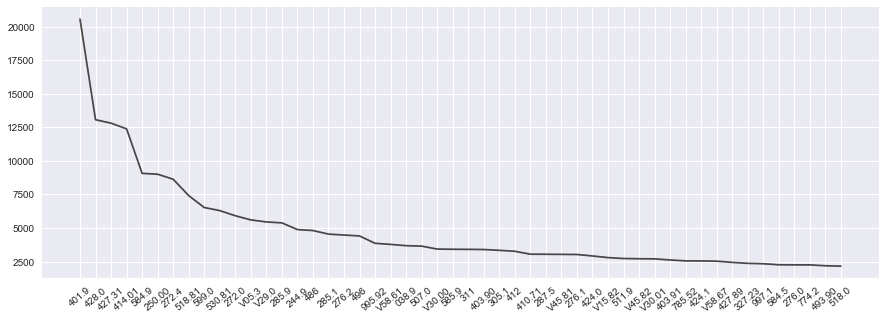

In [14]:
freqs = [elem[1] for elem in counted]
ticks = [elem[0] for elem in counted]

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(np.arange(50), ticks,rotation=40)
ax.plot(freqs, 'black', alpha=0.7)
plt.show()
fig.savefig('./label_freqs_50.pdf', dpi=200, bbox_inches='tight')

In [18]:
Y = 10
#first calculate the top k
counts = Counter()
dfnl = pd.read_csv('./notes_labeled_ls.csv')
for row in dfnl.itertuples():
    for label in str(row[4]).split(';'):
        counts[label] += 1

In [19]:
codes_10 = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
codes_10 = [code[0] for code in codes_10[:Y]]
codes_10

['401.9',
 '428.0',
 '427.31',
 '414.01',
 '584.9',
 '250.00',
 '272.4',
 '518.81',
 '599.0',
 '530.81']

In [25]:
codes_10 = ['401.9',
 '428.0',
 '427.31',
 '414.01',
 '584.9',
 '250.00',
 '272.4',
 '518.81',
 '599.0',
 '530.81']

In [60]:
sum(dict(counts.most_common(10)).values())

105735

In [20]:
Y=10
csv.field_size_limit(sys.maxsize)
for splt in ['train', 'dev', 'test']:
    print(splt)
    hadm_ids = set()
    with open('./hadm_ids/%s_50_hadm_ids.csv' %splt, 'r') as f:
        for line in f:
            hadm_ids.add(line.rstrip())
    with open('./notes_labeled_full.csv', 'r') as f:
        with open('./%s_%s.csv' % (splt, str(Y)), 'w') as of:
            r = csv.reader(f)
            w = csv.writer(of)
            #header
            w.writerow(next(r))
            i = 0
            for row in r:
                hadm_id = row[1]
                if hadm_id not in hadm_ids:
                    continue
                codes = set(str(row[4]).split(';'))
                filtered_codes = codes.intersection(set(codes_10))
                if len(filtered_codes) > 0:
                    w.writerow(row[:4] + [';'.join(filtered_codes)])
                    i += 1

train
dev
test


In [21]:
for splt in ['train', 'dev', 'test']:
    filename = './%s_%s.csv' % (splt, str(Y))
    df = pd.read_csv(filename)
    df['length'] = df.apply(lambda row: len(str(row['TEXT']).split()), axis=1)
    df = df.sort_values(['length'])
    df.to_csv('./%s_%s.csv' % (splt, str(Y)), index=False)

In [68]:
# split labels by ";", then convert to list
def split_lab (x):
    #print(x)
    return x.split(";")

In [ ]:
labeled_ls['TEXT'] = labeled_ls['TEXT'].apply(split_lab)

In [10]:
labeled_ls['TEXT']



0        [neonatology attending triage note baby name n...
1        [pm ct abdomen w o contrast ct pelvis w o cont...
2        [pm chest portable ap clip clip number radiolo...
3        [nnp triage note bb known lastname delivered a...
4        [pm abdomen supine only in o r clip clip numbe...
                               ...                        
58269    [yo male pt with h o pna transffered from 11r ...
58270    [am chest pa lat clip clip number radiology re...
58271    [pm chest portable ap clip clip number radiolo...
58272    [pm chest port line placement clip clip number...
58273    [chief complaint respiratory distress hpi yo f...
Name: TEXT, Length: 58274, dtype: object

In [9]:
train_50 = pd.read_csv('./train_50.csv', index_col=None)
#dev_50 = pd.read_csv('./datasets_allnotes/dev_50.csv', index_col=None)
#test_50 = pd.read_csv('./datasets_allnotes/test_50.csv', index_col=None)

#full_50 = pd.concat([train_50, dev_50, test_50], ignore_index=True)

In [69]:
full_50['LABELS'] = full_50['LABELS'].apply(split_lab)

In [71]:
np.mean(full_50.LABELS.str.len())

4.761853058269996

In [22]:
train_10 = pd.read_csv('./train_10.csv', index_col=None)
#dev_10 = pd.read_csv('./datasets_allnotes/dev_10.csv', index_col=None)
#test_10 = pd.read_csv('./datasets_allnotes/test_10.csv', index_col=None)

#full_10 = pd.concat([train_10, dev_10, test_10], ignore_index=True)

In [73]:
full_10['LABELS'] = full_10['LABELS'].apply(split_lab)

In [74]:
np.mean(full_10.LABELS.str.len())

2.576752064365869

In [79]:
sum(counts.values())/len(dfnl)

11.06956700536317

In [24]:
train_50['TEXT'] = train_50['TEXT'].apply(split_lab)

In [26]:
len(train_50['TEXT'][7810])

1132

<AxesSubplot:xlabel='TEXT', ylabel='Density'>

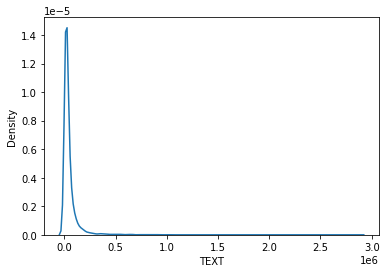

In [65]:
sns.kdeplot(train_50.TEXT.str.len())

In [37]:
train_50.TEXT.str.len().describe()

count    7665.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: TEXT, dtype: float64

In [10]:
train_50


,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,LABELS


In [30]:
train_10 = pd.read_csv('./train_10.csv', index_col=None)

In [31]:
train_10

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,26993,194796,admission date discharge date date of birth se...,401.9;414.01;272.4;250.00,367
1,21692,178071,admission date discharge date service medicine...,401.9;427.31;414.01,392
2,5437,113097,normal sinus rhythm borderline prolonged q tc ...,401.9;530.81;250.00,399
3,24464,145442,sinus tachycardia right ventricular conduction...,401.9,401
4,3535,157294,am chest portable ap clip reason s p trach ___...,250.00,406
5,1579,169054,sinus rhythm normal ecg compared to the previo...,401.9,413
6,18066,178471,admission date discharge date date of birth se...,401.9,442
7,17540,110176,trauma icu nursing progress note review of sys...,250.00,445
8,18552,120398,micu sicu nsg note this is an y o woman with p...,518.81;401.9;250.00,452
9,21457,118648,poor quality tracing sinus rhythm early r wave...,401.9,460
